In [1]:
import pickle

In [3]:
#rnd1k_ep1_nst_arcs = pickle.load(open('lf_kd_ep1_c10.pickle', 'rb'))      # CIFAR10
#rnd1k_ep1_nst_arcs = pickle.load(open('lf_kd_ep1.pickle', 'rb'))          # CIFAR100
rnd1k_ep1_nst_arcs = pickle.load(open('lf_kd_ep1_imagenet.pickle', 'rb')) # ImageNet16-120

rnd1k_ep1_nst_arcs = rnd1k_ep1_nst_arcs_all[0] #!!!! после pull тут будет массив 12*15625 для каждой эпохи

In [4]:
len(rnd1k_ep1_nst_arcs)

15625

In [6]:
%load_ext autoreload

%autoreload 2

In [7]:
import os
import sys
import random
import numpy as np
from tqdm import tqdm_notebook
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt

In [8]:
import mfgpr

In [9]:
import pickle
obj = pickle.load(open('nasbench_val.pkl', 'rb'))

In [10]:
#(lf_val, lf_test, hf_val, hf_test) = pickle.load(open('acc_nb201_c10.pickle', 'rb'))      # CIFAR 10
#(lf_val, lf_test, hf_val, hf_test) = pickle.load(open('acc_nb201.pickle', 'rb'))          # CIFAR 100
(lf_val, lf_test, hf_val, hf_test) = pickle.load(open('acc_nb201_imagenet.pickle', 'rb'))  # ImageNet

In [11]:
n = 1563

ys2 = obj['ys'][n:] + obj['ys'][:n]
X2 = obj['descriptors'][n:] + obj['descriptors'][:n]
gs2 = obj['gs'][n:] + obj['gs'][:n]

In [12]:
len(lf_val)

15625

In [13]:
len(rnd1k_ep1_nst_arcs)

15625

In [14]:
obj['path_to_model']

'./logs/WassersteinVAE_RBF/version_23'

In [15]:
kd_pred = rnd1k_ep1_nst_arcs

In [16]:
X_adj = []

for elem in gs2:
    X_adj.append(elem.numpy().flatten())

Text(0, 0.5, 'hf_test')

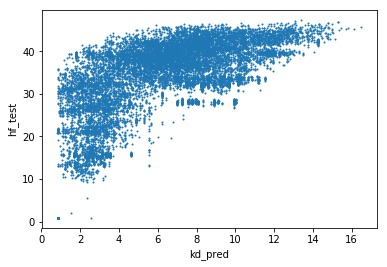

In [17]:
plt.scatter(kd_pred, hf_test, s=1)
plt.xlabel('kd_pred')
plt.ylabel('hf_test')

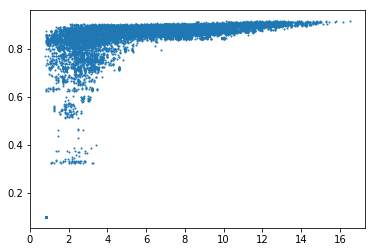

In [18]:
plt.scatter(kd_pred, ys2, s=1)

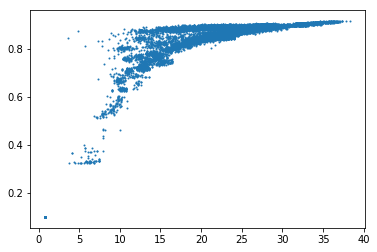

In [19]:
plt.scatter(lf_test, ys2, s=1)

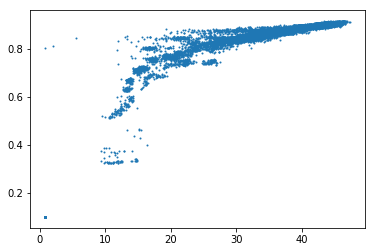

In [20]:
plt.scatter(hf_test, ys2, s=1)

In [21]:
N = 150

In [22]:
trials = 100
acc_rs_hf = np.zeros(N)
sz = N
costs_rs_hf = np.cumsum([200]*sz)
for trial in range(trials):
    points = list(np.random.choice(list(range(len(X2))), size = N, replace = False))
    
    y_val_points = [hf_val[x] for x in points]
    y_points = np.zeros(N)
    
    for i in range(len(y_points)):
        k = np.argmax(y_val_points[0:i+1])
        y_points[i] = hf_test[points[k]]
    
    acc_rs_hf += np.array(y_points)

In [23]:
trials = 500

sz = int(N*200/12)
acc_rs_lf = np.zeros(sz)
costs_rs_lf = np.cumsum([12]*sz)
acc_rs_lf_all_trials = []
for trial in tqdm_notebook(range(trials)):
    points = list(np.random.choice(list(range(len(X2))), size = sz, replace = False))
    
    y_val_points = [lf_val[x] for x in points]
    y_points = np.zeros(sz)
    
    k = 0
    for i in range(len(y_points)):
        if y_val_points[i] > y_val_points[k]:
            k = i
        y_points[i] = hf_test[points[k]]
    
    acc_rs_lf += np.array(y_points)
    acc_rs_lf_all_trials.append(np.array(y_points))

In [24]:
acc_rs_lf_all_trials = np.array(acc_rs_lf_all_trials)

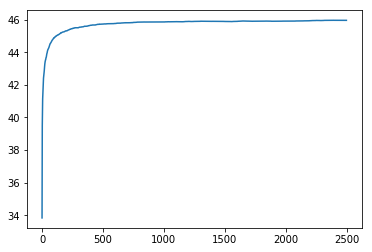

In [25]:
plt.plot(acc_rs_lf_all_trials.mean(axis=0))

In [26]:
i = np.where(acc_rs_lf_all_trials.mean(axis=0) >= 44.57)[0][0]

In [28]:
i

72

In [29]:
acc_rs_lf_all_trials.mean(axis=0)[i]

44.57466661624822

In [30]:
acc_rs_lf_all_trials.std(axis=0)[i]

1.2984101217053037

In [31]:
trials = 100

sz = min([int(N*200/1.5), len(X2)])
acc_rs_kd = np.zeros(sz)
costs_rs_kd = np.cumsum([1.5]*sz)

for trial in tqdm_notebook(range(trials)):
    points = list(np.random.choice(list(range(len(X2))), size = sz, replace = False))
    
    y_val_points = [kd_pred[x] for x in points]
    y_points = np.zeros(sz)
    
    k = 0
    for i in range(len(y_points)):
        #k = np.argmax(y_val_points[0:i+1])
        if y_val_points[i] > y_val_points[k]:
            k = i
        y_points[i] = hf_test[points[k]]
    
    acc_rs_kd += np.array(y_points)

In [50]:
def run_MFKDGPR(X_scaled = None, lf_data = None, hf_data = None, max_points = None, r=5, 
                hf_cost=12, lf_cost=1.5, n_init=20):
    refit_each = 5
    #checked_points = list(np.random.choice(list(range(len(data))), size = n_init, replace = False))
    lf_checked_points = list(np.random.choice(list(range(len(lf_data))), size = r*n_init, replace = False))
    
    hf_checked_points = list(np.random.choice(list(range(len(hf_data))), size = n_init, replace = False))
    
    costs = []
    costs.append(hf_cost + n_init*r*lf_cost) # include initial cost for low-fidelity
    for i in range(1, n_init):
        costs.append(hf_cost)
    
    X_train_lf = [X_scaled[idx] for idx in lf_checked_points] 
    X_train_hf = [X_scaled[idx] for idx in hf_checked_points] 
    y_train_lf = [lf_data[idx] for idx in lf_checked_points]
    y_train_hf = [hf_data[idx] for idx in hf_checked_points]
        
    composite_kernel = RBF(length_scale=1, length_scale_bounds=(0.001, 100))
    composite_kernel = ConstantKernel(1, constant_value_bounds=(0.001, 100)) * composite_kernel
    composite_kernel = WhiteKernel(noise_level=1, noise_level_bounds=(0.001, 100)) + composite_kernel
    
    if r > 0:
        model = mfgpr.GaussianProcessCoKriging(
                kernel=composite_kernel,
                n_restarts_optimizer=1
            )
    else:
        model = GPR(
                kernel=composite_kernel,
                n_restarts_optimizer=1
            )
    
    
        
    pbar = tqdm_notebook(total=max_points)
    pbar.update(n_init)
    
    if r > 0:
        model.fit(np.array(X_train_lf), np.array(y_train_lf), np.array(X_train_hf), np.array(y_train_hf))
    else:
        model.fit(np.array(X_train_hf), np.array(y_train_hf))
    
    while len(hf_checked_points) < max_points:
        # low fidelity x r
        
        # high fidelity
        if len(hf_checked_points) % refit_each == 0:
            if r > 0:
                model.fit(np.array(X_train_lf), np.array(y_train_lf), np.array(X_train_hf), np.array(y_train_hf))
            else:
                model.fit(np.array(X_train_hf), np.array(y_train_hf))
            #model.fit(np.array(X_train_lf), np.array(y_train_lf), np.array(X_train_hf), np.array(y_train_hf))
        
        X_scaled_part = []
        acq_points = list(np.random.choice(list(range(len(hf_data))), size = min([5000, len(hf_data)]), replace = False))


        for idx in acq_points:
            X_scaled_part.append(X_scaled[idx])

        preds, std = model.predict(np.array(X_scaled_part), return_std=True)
        preds = np.hstack((preds.reshape(-1, 1), std.reshape(-1, 1))).T

        max_score = -np.inf
        best_new_idx = None

        for i, idx in enumerate(acq_points):            
            if idx not in hf_checked_points:
                # UCB
                score = preds[0][i] + 1 * preds[1][i] 

                if score > max_score:
                    max_score = score
                    best_new_idx = idx

        if best_new_idx is not None:
            hf_checked_points.append(best_new_idx)
            costs.append(hf_cost)
            y_train_hf.append(hf_data[best_new_idx])
            X_train_hf.append(X_scaled[best_new_idx])
        pbar.update(1)
    return hf_checked_points, y_train_hf, costs

In [51]:
gpr_trials = 100

N_lf = 95

acc_gpr = np.zeros(N_lf)
all_costs = np.zeros(N_lf)
acc_gpr_all_trials = []
for trial in tqdm_notebook(range(gpr_trials)):
    points, y_train, costs = run_MFKDGPR(X_adj, [], [x/100 for x in lf_val], N_lf, 
                                         hf_cost=12, r=0)
    
    y_points = np.zeros(N_lf)
    
    for i in range(len(y_points)):
        k = np.argmax(y_train[0:i+1])
        y_points[i] = hf_test[points[k]]
    
    acc_gpr += np.array(y_points)
    all_costs += np.array(costs)
    acc_gpr_all_trials.append(np.array(y_points))

all_costs_gpr = np.cumsum(all_costs/gpr_trials)

acc_gpr_all_trials = np.array(acc_gpr_all_trials)

In [33]:
mfkdgpr_trials = 100

In [34]:
N_lf = 75

In [35]:
acc_mfkdgpr = np.zeros(N_lf)
all_costs = np.zeros(N_lf)
acc_mfkdgpr_all_trials = []
for trial in tqdm_notebook(range(mfkdgpr_trials)):
    points, y_train, costs = run_MFKDGPR(X_adj, [x/100 for x in kd_pred], [x/100 for x in lf_val], N_lf, 
                                         hf_cost=12)
    
    y_points = np.zeros(N_lf)
    
    for i in range(len(y_points)):
        k = np.argmax(y_train[0:i+1])
        y_points[i] = hf_test[points[k]]
    
    acc_mfkdgpr += np.array(y_points)
    all_costs += np.array(costs)
    acc_mfkdgpr_all_trials.append(np.array(y_points))

/home/fmsnew/NAS/wae/mfgpr.py:539: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.12644237e+00,  1.62252945e+01,  9.26547727e-04,  0.00000000e+00,
        1.03989350e+00,  5.11590770e-05,  0.00000000e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 408, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


/home/fmsnew/NAS/wae/mfgpr.py:539: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.81330506e-03, 4.25948770e+00, 4.50199877e-03, 0.00000000e+00,
       6.96297775e-01, 8.86757334e-04, 0.00000000e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 448, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


In [36]:
acc_mfkdgpr_all_trials = np.array(acc_mfkdgpr_all_trials)

In [37]:
all_costs_kd_lf = np.cumsum(all_costs/mfkdgpr_trials)

In [38]:
i = np.where(acc_rs_lf_all_trials.mean(axis=0) >= 44.57)[0][0]

In [39]:
acc_mfkdgpr_all_trials.mean(axis=0)[i]

45.809444396633545

In [40]:
acc_mfkdgpr_all_trials.std(axis=0)[i]

0.9389465790407671

In [52]:
acc_gpr_all_trials.mean(axis=0)[i]

45.47588883463541

In [53]:
acc_gpr_all_trials.std(axis=0)[i]

0.9843329037352019

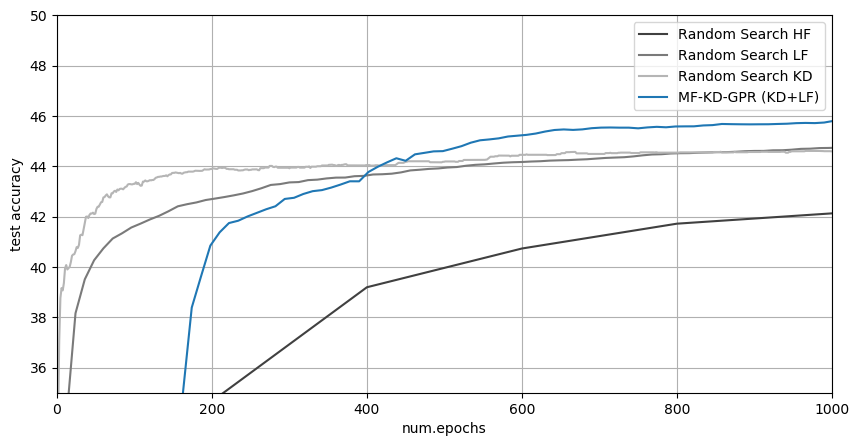

In [42]:
plt.figure(figsize=(10, 5), dpi=100)

plt.plot(costs_rs_hf, acc_rs_hf/trials, label = 'Random Search HF', color=plt.cm.Greys(0.8))
plt.plot(costs_rs_lf, acc_rs_lf_all_trials.mean(axis=0), label = 'Random Search LF', color=plt.cm.Greys(0.6))
plt.plot(costs_rs_kd, acc_rs_kd/trials, label = 'Random Search KD', color=plt.cm.Greys(0.4))
plt.plot(all_costs_kd_lf, acc_mfkdgpr_all_trials.mean(axis=0), label = 'MF-KD-GPR (KD+LF)')
# plt.plot(all_costs_kd_hf, acc_mfkdgpr_hf/mfkdgpr_trials, label = 'MF-KD-GPR (KD+HF)')
# plt.plot(costs_rs_hf[xs_b.astype(int) - 1], acc_b, label='BANANAS')
plt.ylim(35, 50) # cifar100
plt.xlim([0, 1000])
plt.xlabel('num.epochs')
plt.ylabel('test accuracy')
plt.legend()
#plt.yticks(range(65, 75));
plt.grid()

In [57]:
save_dict  = {
    'costs_rs_hf':costs_rs_hf,
    'costs_rs_lf':costs_rs_lf,
    'costs_rs_kd':costs_rs_kd,
    'acc_rs_hf':acc_rs_hf,
    'acc_rs_lf_all_trials':acc_rs_lf_all_trials,
    'acc_rs_kd':acc_rs_kd,
    'all_costs_kd_lf':all_costs_kd_lf,
    'acc_mfkdgpr_all_trials':acc_mfkdgpr_all_trials,
    'mfkdgpr_trials':mfkdgpr_trials,
    'trials':trials,
    'acc_gpr_all_trials':acc_gpr_all_trials, 
    'all_costs_gpr':all_costs_gpr
        
}

pickle.dump(save_dict, open('NB201_KD_results_new_save_dict_imagenet.pkl', 'wb'))

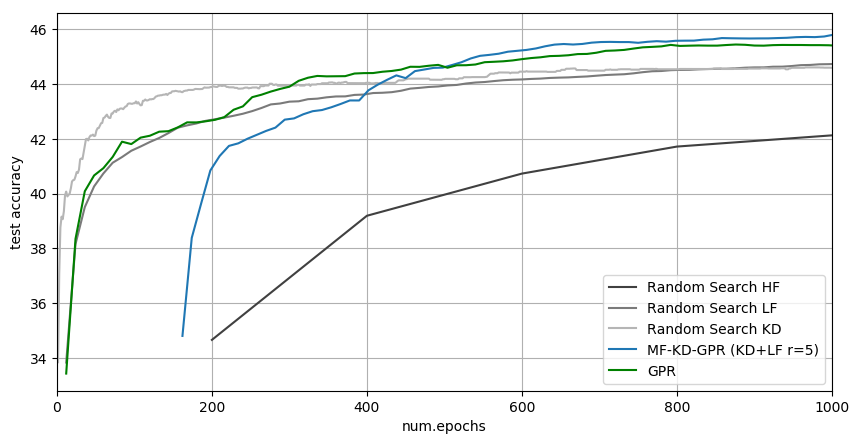

In [56]:
plt.figure(figsize=(10, 5), dpi=100)

plt.plot(costs_rs_hf, acc_rs_hf/trials, label = 'Random Search HF', color=plt.cm.Greys(0.8))
plt.plot(costs_rs_lf, acc_rs_lf_all_trials.mean(axis=0), label = 'Random Search LF', color=plt.cm.Greys(0.6))
plt.plot(costs_rs_kd, acc_rs_kd/trials, label = 'Random Search KD', color=plt.cm.Greys(0.4))
plt.plot(all_costs_kd_lf, acc_mfkdgpr_all_trials.mean(axis=0), label = 'MF-KD-GPR (KD+LF r=5)')
plt.plot(all_costs_gpr, acc_gpr_all_trials.mean(axis=0), label = 'GPR', color='green')
#plt.ylim(90, 95) # cifar100
plt.xlim([0, 1000])
plt.xlabel('num.epochs')
plt.ylabel('test accuracy')
plt.legend()
#plt.yticks(range(65, 75));
plt.grid()

In [99]:
acc_mfkdgpr_hf = np.zeros(N)
all_costs = np.zeros(N)

for trial in tqdm_notebook(range(mfkdgpr_trials)):
    points, y_train, costs = run_MFKDGPR(X_adj, [x/100 for x in kd_pred], [x/100 for x in hf_val], N, hf_cost=200)
    
    y_points = np.zeros(N)
    
    for i in range(len(y_points)):
        k = np.argmax(y_train[0:i+1])
        y_points[i] = hf_test[points[k]]
    
    acc_mfkdgpr_hf += np.array(y_points)
    all_costs += np.array(costs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [100]:
all_costs_kd_hf = np.cumsum(all_costs/mfkdgpr_trials)

In [64]:
# save_dict  = {
#     'acc_rs':acc_rs,
# 'acc_gp':acc_gp,
# 'acc_gp_adj':acc_gp_adj,
# 'acc_mfgp_adj_kd':acc_mfgp_adj_kd,
# 'acc_mfgp_adj':acc_mfgp_adj,
# 'gp_trials':gp_trials,
# 'mfgp_trials':mfgp_trials
# }

#pickle.dump(save_dict, open('NB201_KD_results_save_dict', 'wb'))

In [103]:
save_dict  = {
    'costs_rs_hf':costs_rs_hf,
    'costs_rs_lf':costs_rs_lf,
    'costs_rs_kd':costs_rs_kd,
    'acc_rs_hf':acc_rs_hf,
    'acc_rs_lf':acc_rs_lf,
    'acc_rs_kd':acc_rs_kd,
    'all_costs_kd_lf':all_costs_kd_lf,
    'all_costs_kd_hf':all_costs_kd_hf,
    'acc_mfkdgpr':acc_mfkdgpr,
    'acc_mfkdgpr_hf':acc_mfkdgpr_hf,
    'mfkdgpr_trials':mfkdgpr_trials,
    'trials':trials,
    'xs_b':xs_b,
    'acc_b':acc_b
        
}

#pickle.dump(save_dict, open('NB201_KD_results_new_save_dict.pkl', 'wb'))

In [36]:
b_fld = '/home/fmsnew/misc/local_search/results_output/bananas/'

err_b = []
for f in os.listdir(b_fld):
    tmp = pickle.load(open(os.path.join(b_fld, f), 'rb'))
    err_b.append(tmp[2][0][:, 1])
xs_b = tmp[2][0][:, 0]

acc_b = 100 - np.array(err_b).mean(axis=0)

acc_b

array([69.812716, 70.762052, 71.443802, 71.884896, 72.354057, 72.641458,
       72.909237, 73.04625 , 73.192811, 73.253908, 73.286072, 73.300639,
       73.305838, 73.349637, 73.358537])

In [51]:
len(costs_rs_hf)

150

In [70]:
all_costs

array([ 162.,  174.,  186.,  198.,  210.,  222.,  234.,  246.,  258.,
        270.,  282.,  294.,  306.,  318.,  330.,  342.,  354.,  366.,
        378.,  390.,  402.,  414.,  426.,  438.,  450.,  462.,  474.,
        486.,  498.,  510.,  522.,  534.,  546.,  558.,  570.,  582.,
        594.,  606.,  618.,  630.,  642.,  654.,  666.,  678.,  690.,
        702.,  714.,  726.,  738.,  750.,  762.,  774.,  786.,  798.,
        810.,  822.,  834.,  846.,  858.,  870.,  882.,  894.,  906.,
        918.,  930.,  942.,  954.,  966.,  978.,  990., 1002., 1014.,
       1026., 1038., 1050., 1062., 1074., 1086., 1098., 1110., 1122.,
       1134., 1146., 1158., 1170., 1182., 1194., 1206., 1218., 1230.,
       1242., 1254., 1266., 1278., 1290., 1302., 1314., 1326., 1338.,
       1350., 1362., 1374., 1386., 1398., 1410., 1422., 1434., 1446.,
       1458., 1470., 1482., 1494., 1506., 1518., 1530., 1542., 1554.,
       1566., 1578., 1590., 1602., 1614., 1626., 1638., 1650., 1662.,
       1674., 1686.,

In [37]:
save_dict = pickle.load(open('NB201_KD_results_new_save_dict.pkl', 'rb'))

In [38]:
costs_rs_hf = save_dict['costs_rs_hf']
costs_rs_lf = save_dict['costs_rs_lf']
costs_rs_kd = save_dict['costs_rs_kd']
acc_rs_hf = save_dict['acc_rs_hf']
acc_rs_lf = save_dict['acc_rs_lf']
acc_rs_kd = save_dict['acc_rs_kd']
all_costs_kd_lf = save_dict['all_costs_kd_lf']
all_costs_kd_hf = save_dict['all_costs_kd_hf']
acc_mfkdgpr = save_dict['acc_mfkdgpr']
acc_mfkdgpr_hf = save_dict['acc_mfkdgpr_hf']
mfkdgpr_trials = save_dict['mfkdgpr_trials']
trials = save_dict['trials']
xs_b = save_dict['xs_b']
acc_b = save_dict['acc_b']

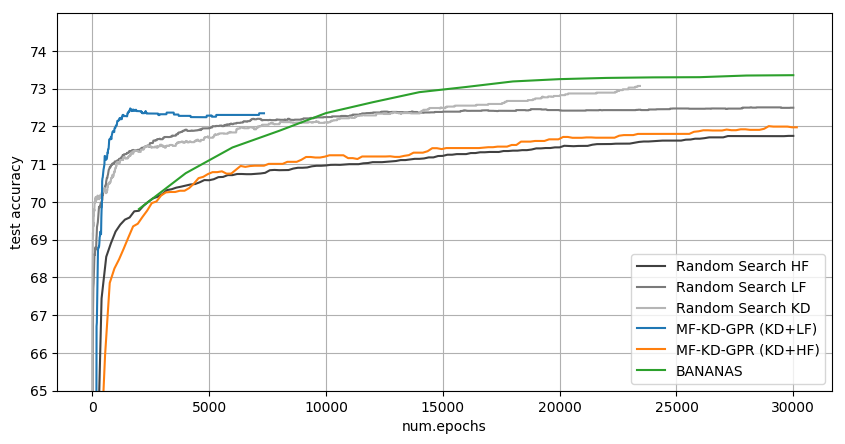

In [47]:
plt.figure(figsize=(10, 5), dpi=100)

plt.plot(costs_rs_hf, acc_rs_hf/trials, label = 'Random Search HF', color=plt.cm.Greys(0.8))
plt.plot(costs_rs_lf, acc_rs_lf/trials, label = 'Random Search LF', color=plt.cm.Greys(0.6))
plt.plot(costs_rs_kd, acc_rs_kd/trials, label = 'Random Search KD', color=plt.cm.Greys(0.4))
plt.plot(all_costs_kd_lf, acc_mfkdgpr/mfkdgpr_trials, label = 'MF-KD-GPR (KD+LF)')
plt.plot(all_costs_kd_hf, acc_mfkdgpr_hf/mfkdgpr_trials, label = 'MF-KD-GPR (KD+HF)')
plt.plot(costs_rs_hf[xs_b.astype(int) - 1], acc_b, label='BANANAS')
plt.ylim(65, 75) # cifar100

plt.xlabel('num.epochs')
plt.ylabel('test accuracy')
plt.legend()
plt.yticks(range(65, 75));
plt.grid()

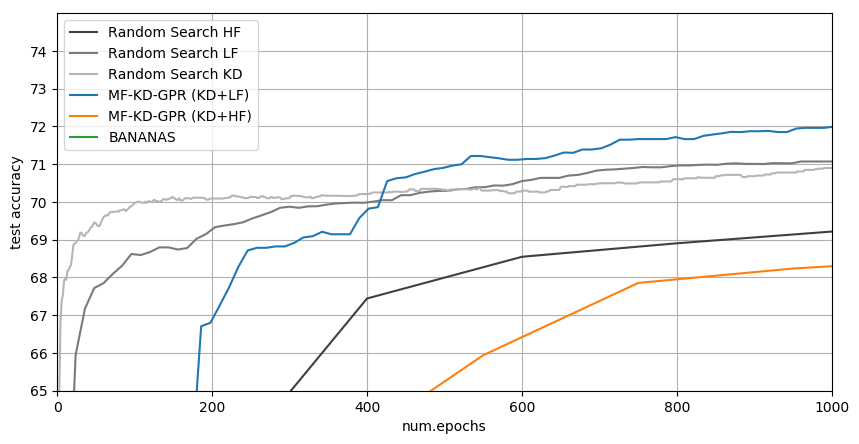

In [46]:
plt.figure(figsize=(10, 5), dpi=100)

plt.plot(costs_rs_hf, acc_rs_hf/trials, label = 'Random Search HF', color=plt.cm.Greys(0.8))
plt.plot(costs_rs_lf, acc_rs_lf/trials, label = 'Random Search LF', color=plt.cm.Greys(0.6))
plt.plot(costs_rs_kd, acc_rs_kd/trials, label = 'Random Search KD', color=plt.cm.Greys(0.4))
plt.plot(all_costs_kd_lf, acc_mfkdgpr/mfkdgpr_trials, label = 'MF-KD-GPR (KD+LF)')
plt.plot(all_costs_kd_hf, acc_mfkdgpr_hf/mfkdgpr_trials, label = 'MF-KD-GPR (KD+HF)')
plt.plot(costs_rs_hf[xs_b.astype(int) - 1], acc_b, label='BANANAS')
plt.ylim(65, 75) # cifar100
plt.xlim([0, 1000])
plt.xlabel('num.epochs')
plt.ylabel('test accuracy')
plt.legend()
plt.yticks(range(65, 75));
plt.grid()

In [38]:
# plt.figure(figsize=(10, 5), dpi=100)

# plt.plot(acc_rs/trials, label = 'Random Search')
# plt.plot(acc_gp/gp_trials, label = 'GP BayesOpt UCB, embeddings')
# plt.plot(acc_gp_adj/gp_trials, label = 'GP BayesOpt UCB, adj. matrix')
# #plt.plot(acc_mfgp/gp_trials, label = 'MF-GP BayesOpt UCB, embeddings')
# plt.plot(acc_mfgp_adj/mfgp_trials, label = 'MF-GP BayesOpt UCB, adj. matrix')
# plt.plot(acc_mfgp_adj_kd/mfgp_trials, label = 'MF-GP BayesOpt UCB, adj. matrix with KD')
# plt.plot(xs_b, acc_b, label='BANANAS')
# plt.ylim(65, 75) # cifar100

# plt.legend()

In [83]:
print(1)

1
